# <b><font color= darkblue>Lead Scoring - Case Study</font></b><br>
### <b><font color = maroon>Problem Statement</font></b><br>

An X Education need help to select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires us to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

### <b><font color = maroon>Goals of Case Study</font></b><br>

Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.

In [1]:
#Importing lib

# Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries for analysis
import pandas as pd, numpy as np

# libraries for visulaization
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import seaborn as sns
%matplotlib inline

# libraries for model building and metrics calculations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
import statsmodels.api as sm

## <font color= darkblue>Step 1: Data Cleaning</font>

### <font color = maroon>1.1 Reading and Understanding Data</font>

In [2]:
df = pd.read_csv('Leads.csv')
print(df.shape)
df.head(5)

(9240, 37)


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [4]:
# Replacing 'Select' with NaN (As it means no option is selected)
df = df.replace('Select', np.nan)

In [5]:
# Checking if there are columns with one unique value since it won't affect our analysis
df.nunique()

Prospect ID                                      9240
Lead Number                                      9240
Lead Origin                                         5
Lead Source                                        21
Do Not Email                                        2
Do Not Call                                         2
Converted                                           2
TotalVisits                                        41
Total Time Spent on Website                      1731
Page Views Per Visit                              114
Last Activity                                      17
Country                                            38
Specialization                                     18
How did you hear about X Education                  9
What is your current occupation                     6
What matters most to you in choosing a course       3
Search                                              2
Magazine                                            1
Newspaper Article           

In [6]:
# Removing Id values since they are unique for everyone
df = df.drop(['Prospect ID'], 1)

# Dropping single valued columns
df = df.drop(['Magazine',
              'Receive More Updates About Our Courses',
              'I agree to pay the amount through cheque',
              'Get updates on DM Content',
              'Update me on Supply Chain Content'],axis=1)

In [7]:
# Checking the percentage of missing values
round(100*(df.isnull().sum()/len(df.index)), 2)

Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

In [8]:
# Removing columns with  >=50% null values
df1 = df.loc[:, round(100*(df.isnull().sum()/len(df.index)), 2) < 50]

In [9]:
# Checking the % of missing values in new dataframe
round(100*(df1.isnull().sum()/len(df1.index)), 2)

Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

### <font color = maroon>1.2 Handling null value columns</font>

#### <font color = green>Observation</font>
`Aysmmetrique Activity Index`, `Asymmetrique Profile Index`, `Asymmetrique Activity Score`, `Asymmetrique Profile Score` 
have highest null percentages

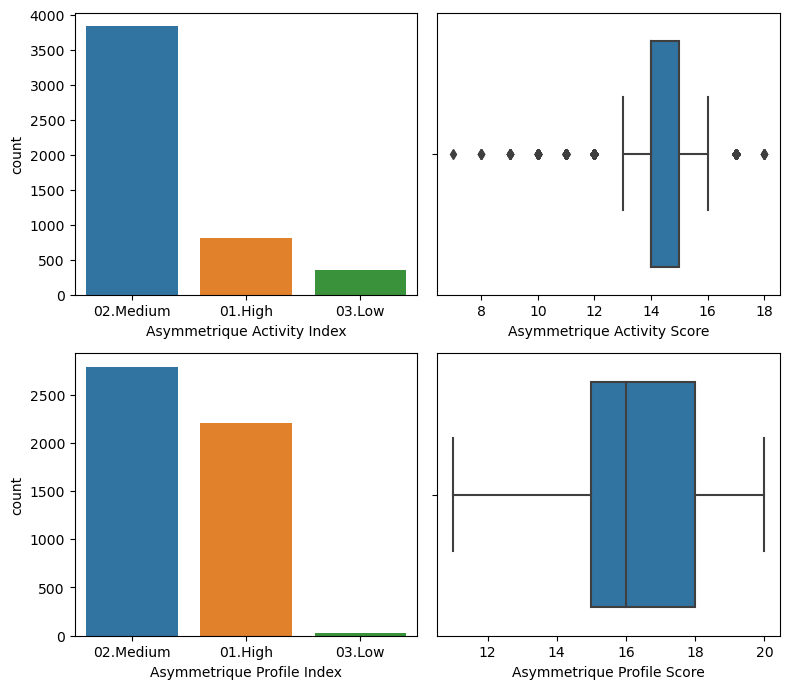

In [10]:
# Visualizing these variables
fig, axs = plt.subplots(2,2, figsize = (8,7))
plt1 = sns.countplot(x = 'Asymmetrique Activity Index', ax = axs[0,0], data=df1)
plt2 = sns.boxplot(x = 'Asymmetrique Activity Score', ax = axs[0,1], data=df1)
plt3 = sns.countplot(x = 'Asymmetrique Profile Index', ax = axs[1,0], data=df1)
plt4 = sns.boxplot(x = 'Asymmetrique Profile Score', ax = axs[1,1], data=df1)
plt.tight_layout()

In [11]:
#We are not getting any business insight also there is too much variation. 
#We can drop the columns

df = df1.drop(['Asymmetrique Activity Index',
               'Asymmetrique Activity Score',
               'Asymmetrique Profile Index',
               'Asymmetrique Profile Score'],1)

#### Observations
`City`, `Specialization`, `Tags`, `Country`, `What matters most to you in choosing a course`, `What is your current occupation`
These 6 columns have the next highest null value percentages

##### Visualizing them to see how to handle these null values

Countplot for City


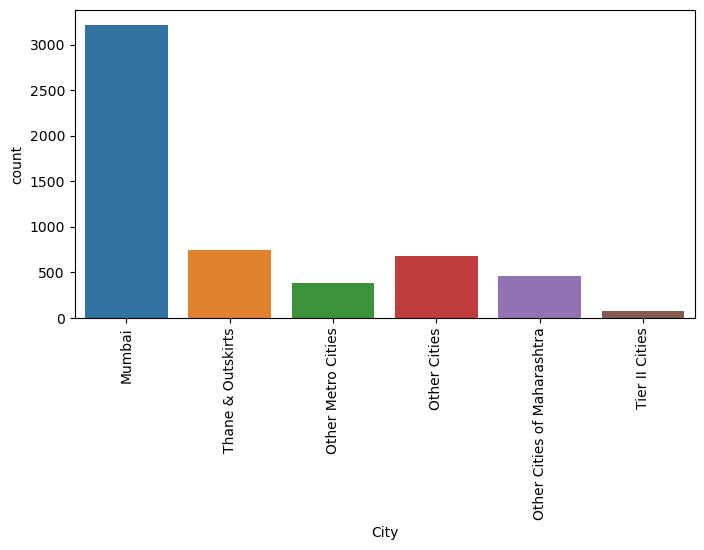

Countplot for Specialization


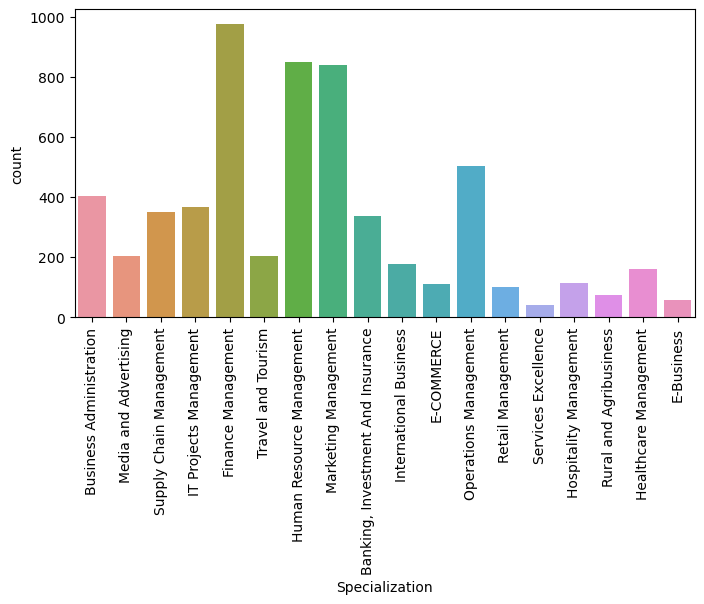

Countplot for Tags


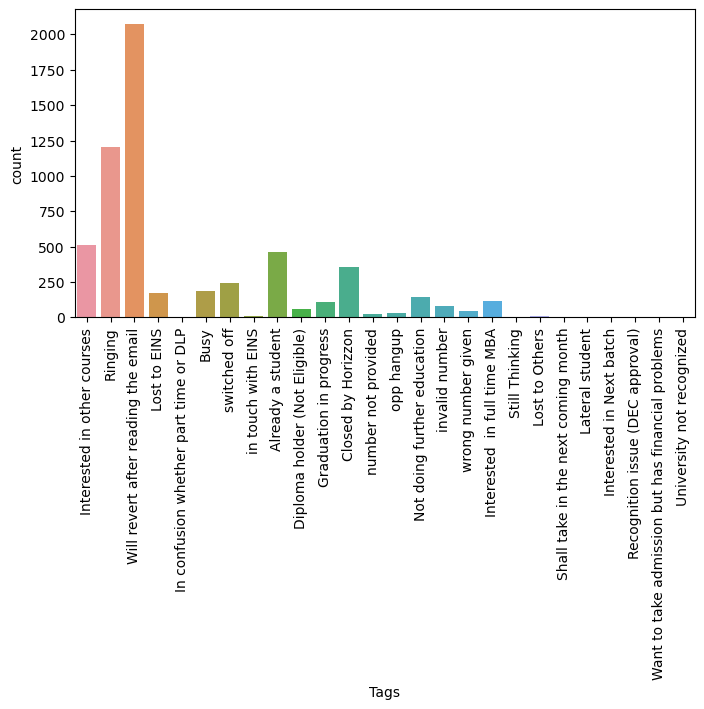

Countplot for Country


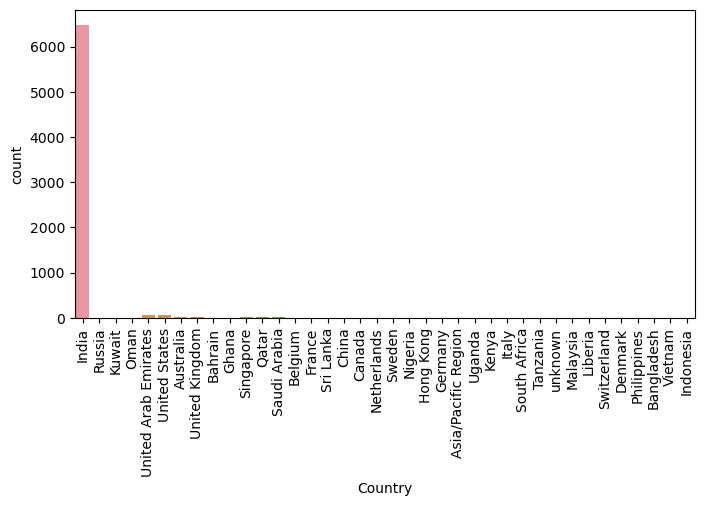

Countplot for What matters most to you in choosing a course


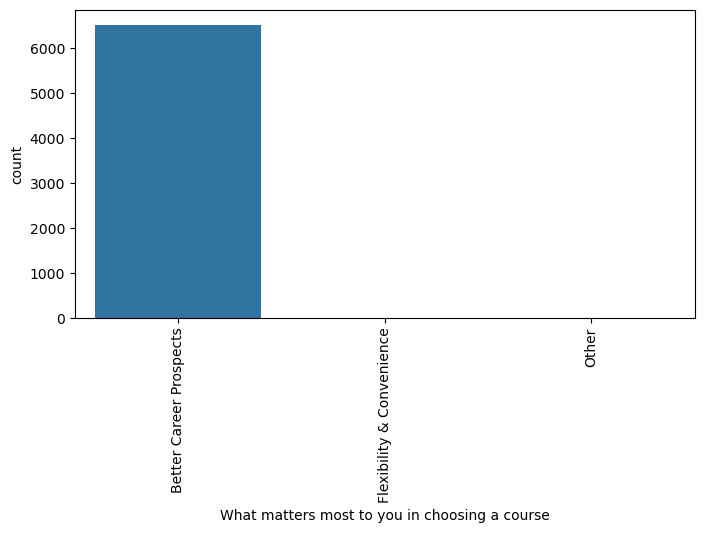

Countplot for What is your current occupation


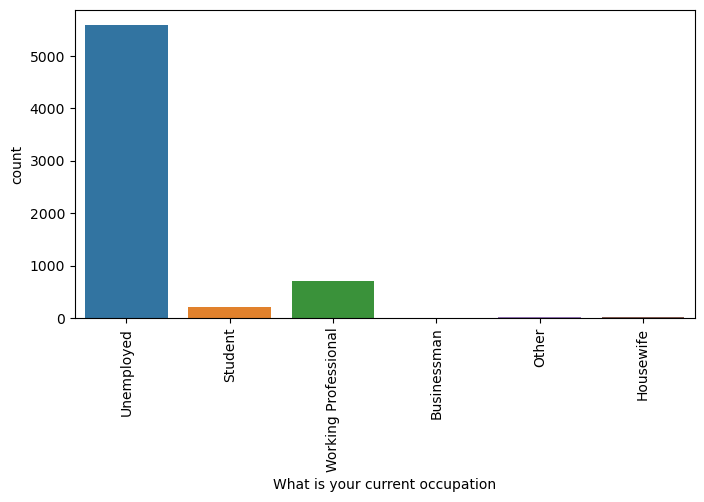

In [12]:
null_val_cols = ['City', 'Specialization', 'Tags', 'Country', 'What matters most to you in choosing a course', 
                 'What is your current occupation']

for col in null_val_cols:
    print("Countplot for", col)
    plt.rcParams["figure.figsize"] = (8,4)
    sns.countplot(x =col, data=df)
    xticks(rotation = 90)
    plt.show()

#Checking Country and City Column percentage distribution
print('Country % distribution')
print(round(100*(df['Country'].value_counts(normalize=True)),2))
print('------------------------------------------------------')
print('City % distribution')
print(round(100*(df['City'].value_counts(normalize=True)),2))

In [13]:
# More than 95% of the total data is country 'India'. 
# Since remaining countries are not that significant, we will drop the country column.
df = df.drop(['Country'], axis=1)

# Around 58% of the total data is city 'Mumbai'. So we will impute Mumbai for NaN values.
df['City'] = df['City'].replace(np.nan, 'Mumbai')

#Remaining four columns do data is unavailable, so we will impute 'Not Provided' for NaN values.
df['Specialization'] = df['Specialization'].replace(np.nan, 'Not Provided')
df['Tags'] = df['Tags'].replace(np.nan, 'Not Provided')
df['What matters most to you in choosing a course'] = df['What matters most to you in choosing a course'].replace(np.nan, 'Not Provided')
df['What is your current occupation'] = df['What is your current occupation'].replace(np.nan, 'Not Provided')

In [14]:
#Use skew() function to find the skewness in data 
round(df.skew(skipna=True),2)

Lead Number                     0.14
Converted                       0.47
TotalVisits                    19.91
Total Time Spent on Website     0.96
Page Views Per Visit            2.87
dtype: float64

##### If skewness is less than -1 or greater than 1, the distribution is highly skewed.

#### Observation
We can see that TotalVisits is highly skewed towards right. So we need to treat the outlier while performing EDA

In [15]:
# Verifying the null values for all the columns now again after imputing high null value columns
round(100*(df.isnull().sum()/len(df.index)), 2)

Lead Number                                      0.00
Lead Origin                                      0.00
Lead Source                                      0.39
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.48
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.48
Last Activity                                    1.11
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Newspaper Article                                0.00
X Education Forums                               0.00
Newspaper                                        0.00
Digital Advertisement                            0.00
Through Recommendations     

#### Observation
The remaining columns have less than 2% missing data which is very less. 

##### As it would not impact our EDA we will keep it as it is.

## <font color= darkblue>Step 2: EDA</font>

### <font color = maroon>2.1 Univariate Analysis</font>

#### <font color = maroon>2.1.1 Categorical Variables</font>

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 23 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Number                                    9240 non-null   int64  
 1   Lead Origin                                    9240 non-null   object 
 2   Lead Source                                    9204 non-null   object 
 3   Do Not Email                                   9240 non-null   object 
 4   Do Not Call                                    9240 non-null   object 
 5   Converted                                      9240 non-null   int64  
 6   TotalVisits                                    9103 non-null   float64
 7   Total Time Spent on Website                    9240 non-null   int64  
 8   Page Views Per Visit                           9103 non-null   float64
 9   Last Activity                                  9137 

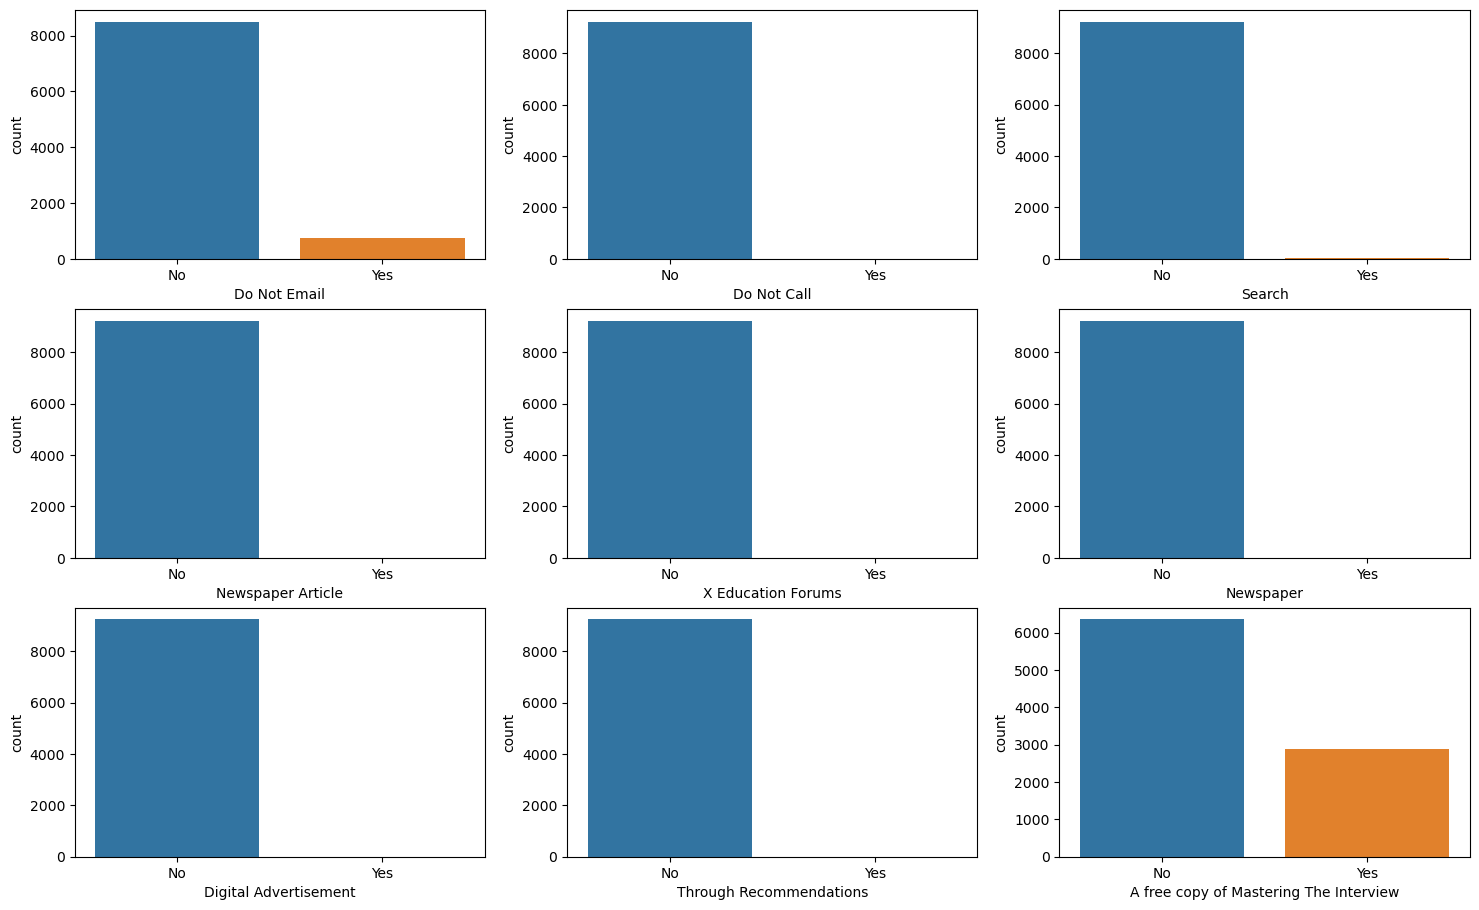

In [17]:
# Analyzing few Category columns
cat_cols = [ 'Do Not Email', 'Do Not Call',   
            'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper', 
            'Digital Advertisement', 'Through Recommendations',
            'A free copy of Mastering The Interview']

fig, ax = plt.subplots(3,3, figsize = (18,11))
counter=0
for i in cat_cols:
    trace_x = counter // 3
    trace_y = counter % 3
    sns.countplot(x=i,ax=ax[trace_x, trace_y], data=df)
    counter += 1
plt.show()

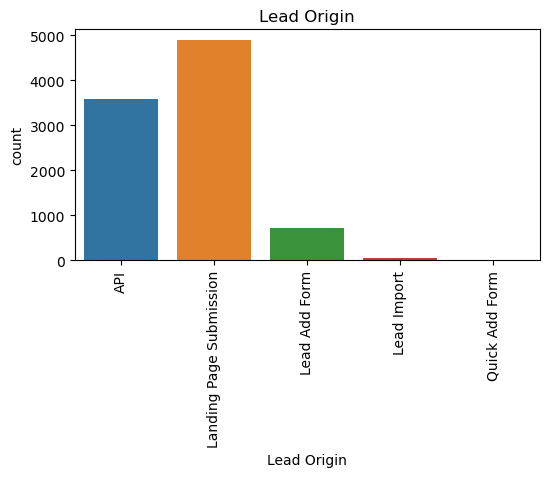

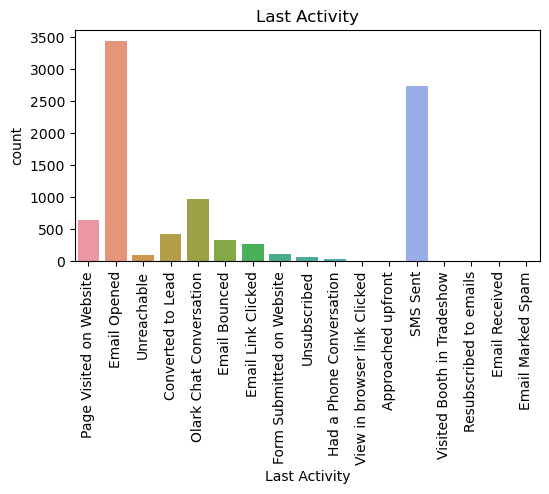

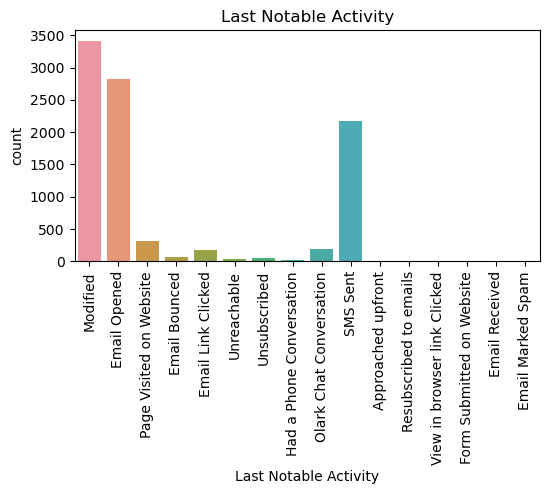

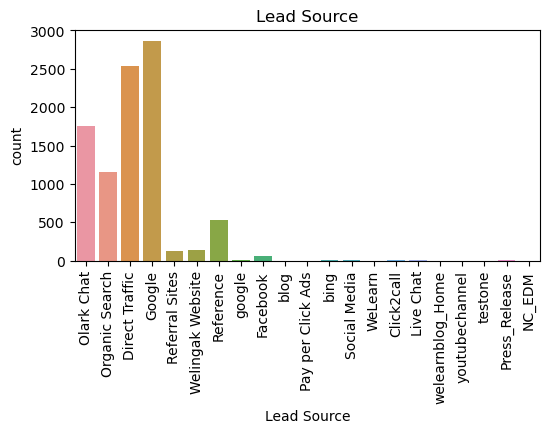

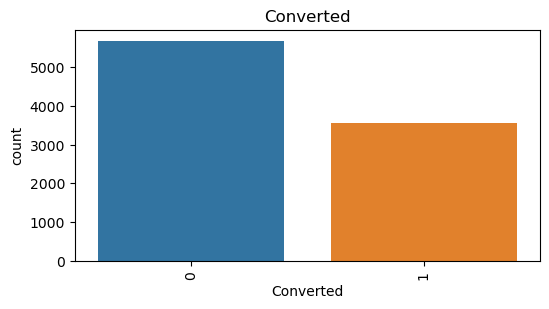

In [18]:
#Function to plot countplot
def plot_countplot(column, dataframe):
    plt.figure(figsize=(6,3))
    sns.countplot(x=column, data=dataframe).tick_params(axis='x', rotation = 90)
    plt.title(column)
    plt.show()

# Analyzing remaining category columns
remaining_cat_cols = ['Lead Origin', 'Last Activity', 'Last Notable Activity', 'Lead Source', 'Converted']
for col in remaining_cat_cols:
    plot_countplot(col, df)

#### <font color = maroon>2.1.2 Numerical Variables</font>

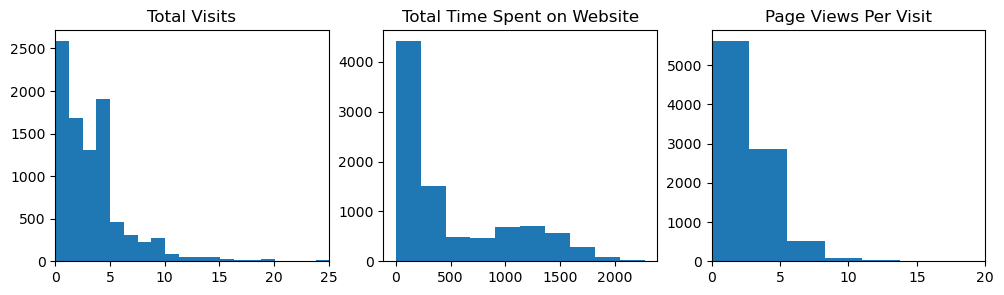

In [19]:
plt.figure(figsize = (12,3))
plt.subplot(131)
plt.hist(df['TotalVisits'], bins = 200)
plt.title('Total Visits')
plt.xlim(0,25)

plt.subplot(132)
plt.hist(df['Total Time Spent on Website'], bins = 10)
plt.title('Total Time Spent on Website')

plt.subplot(133)
plt.hist(df['Page Views Per Visit'], bins = 20)
plt.title('Page Views Per Visit')
plt.xlim(0,20)
plt.show()

### <font color = maroon>2.2 Bivariate Analysis</font>

##### Relating important variables to Converted variable

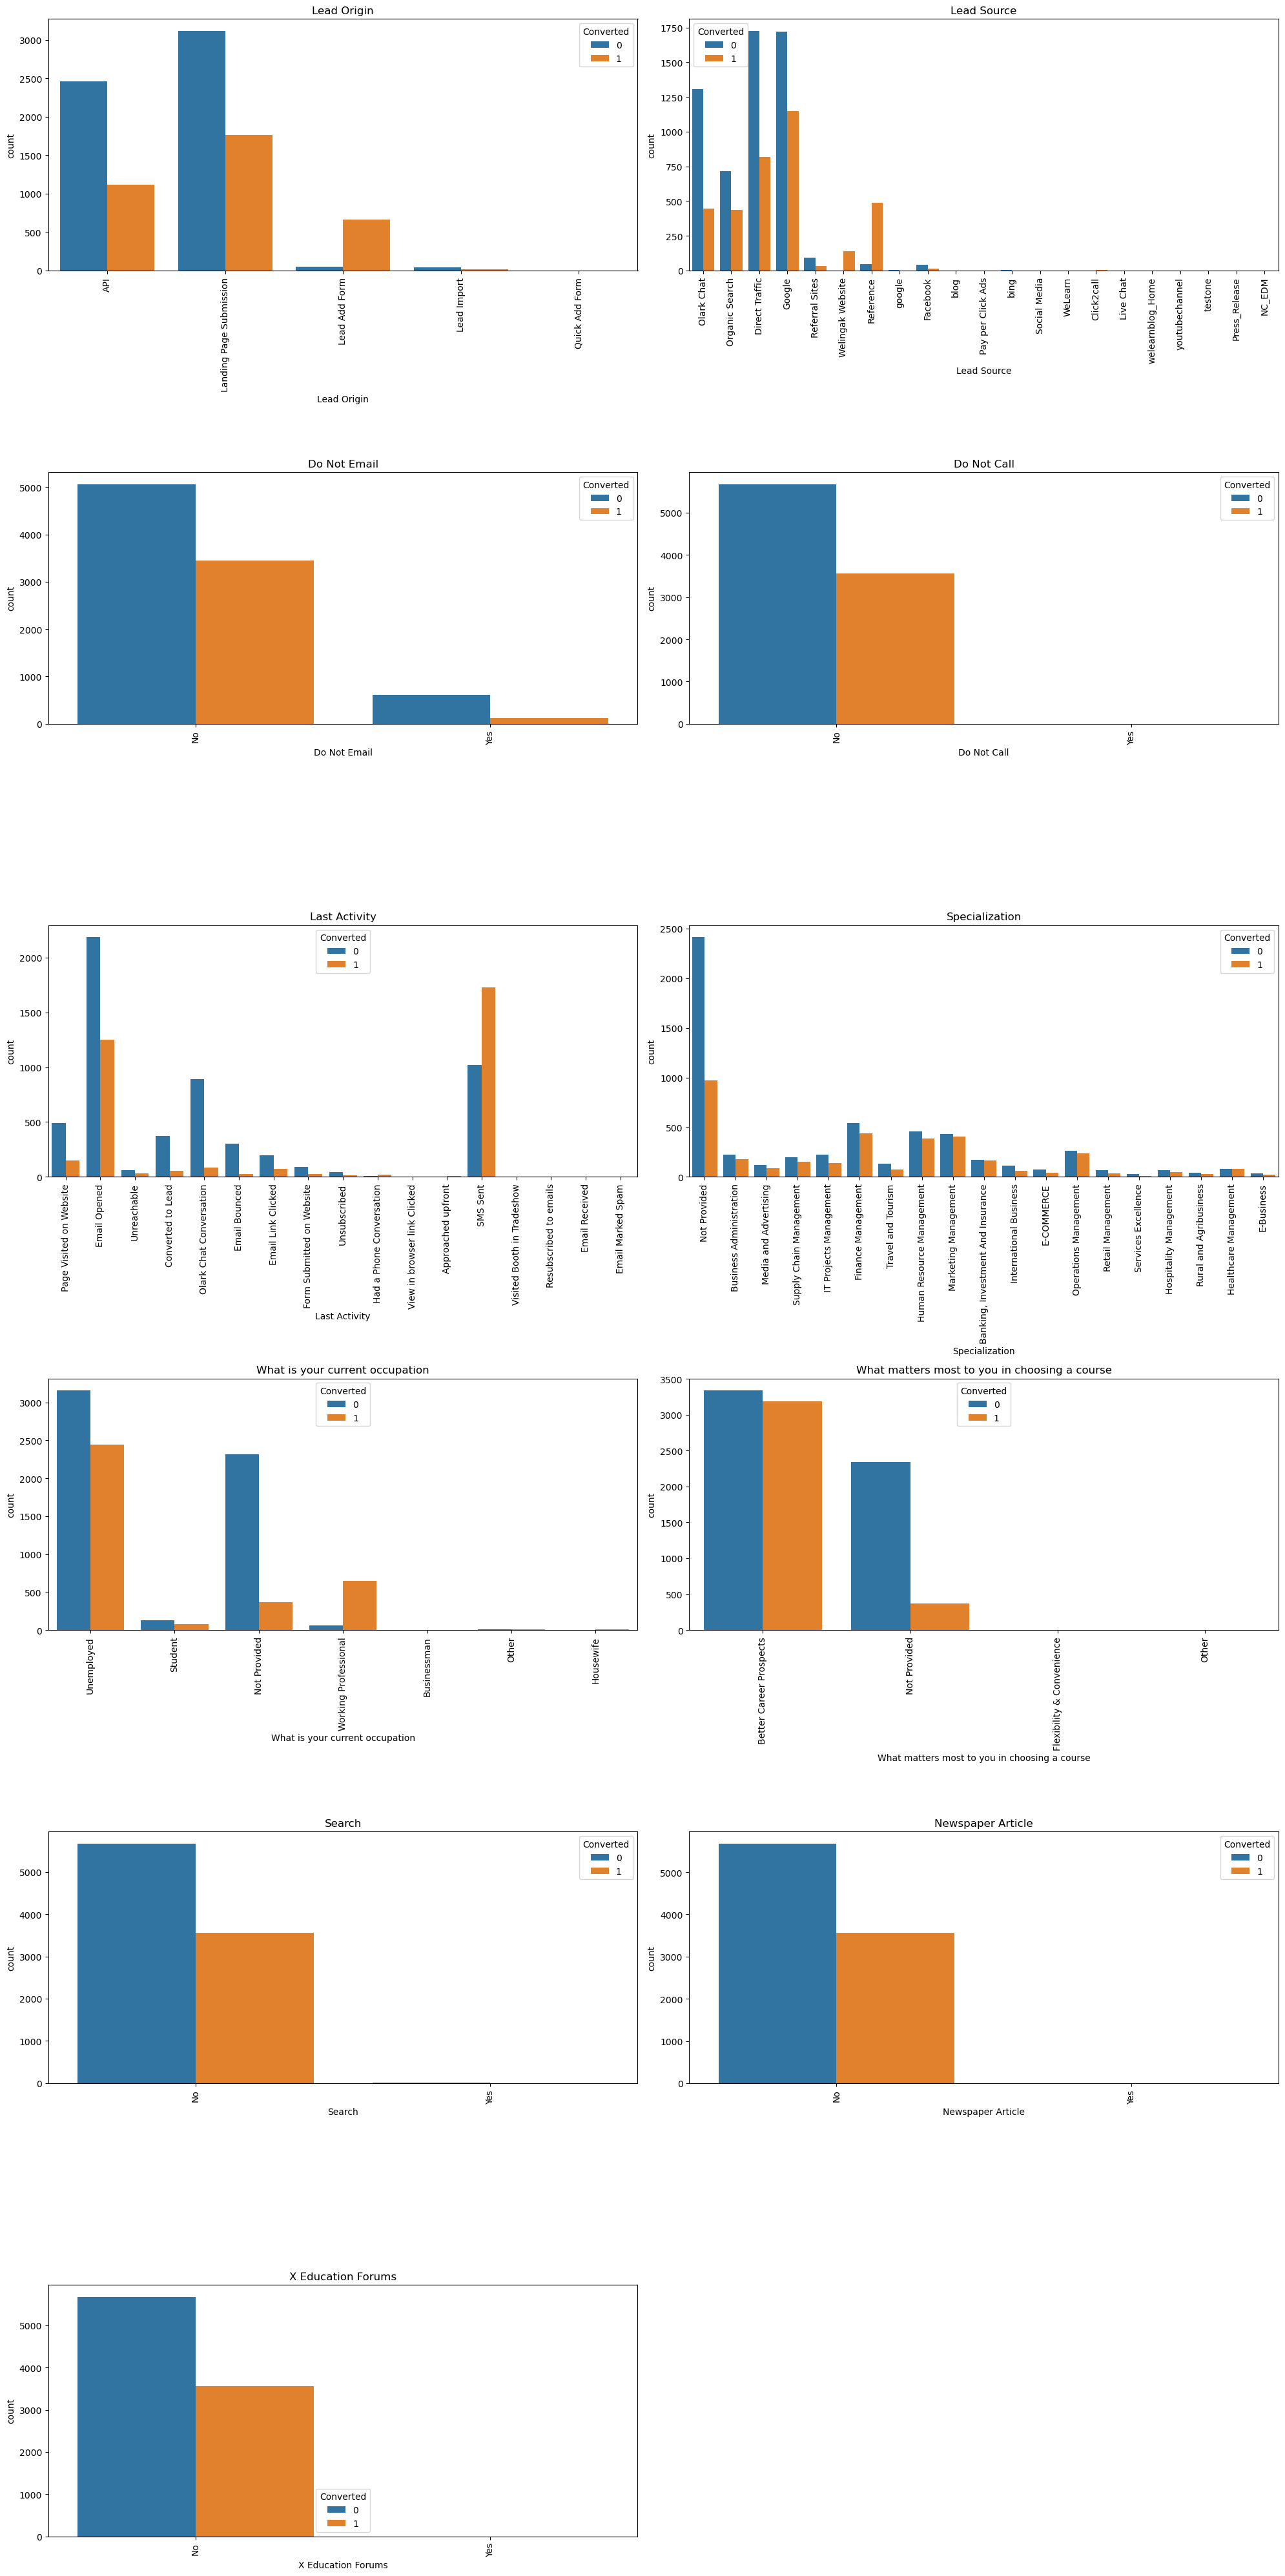

In [20]:
plt.figure(figsize = (20, 40))

# Function to plot upto 12 bivariate countplots
def plot_bivariate_countplot(fignum, x_col, hue_col, dataframe):
    plt.subplot(6,2,fignum)
    sns.countplot(x=x_col, hue=hue_col, data=dataframe).tick_params(axis='x', rotation = 90)
    plt.title(x_col)

plot_bivariate_countplot(1,'Lead Origin', 'Converted', df)
plot_bivariate_countplot(2,'Lead Source', 'Converted', df)
plot_bivariate_countplot(3,'Do Not Email', 'Converted', df)
plot_bivariate_countplot(4,'Do Not Call', 'Converted', df)
plot_bivariate_countplot(5,'Last Activity', 'Converted', df)
plot_bivariate_countplot(6,'Specialization', 'Converted', df)
plot_bivariate_countplot(7,'What is your current occupation', 'Converted', df)
plot_bivariate_countplot(8,'What matters most to you in choosing a course', 'Converted', df)
plot_bivariate_countplot(9,'Search', 'Converted', df)
plot_bivariate_countplot(10,'Newspaper Article', 'Converted', df)
plot_bivariate_countplot(11,'X Education Forums', 'Converted', df)

plt.tight_layout()
plt.show()

In [21]:
# Lead Source- nan values can be replaced with Null value
df['Lead Source'] = df['Lead Source'].fillna('Null')

# As observed from plot above, many lead sources do not contribute much
# Replacing all other categories having low or no conversion into other platforms.
df['Lead Source'] = df['Lead Source'].replace(['google'], 'Google')
df['Lead Source'] = df['Lead Source'].replace([ 'blog', 'Pay per Click Ads', 'bing', 'Social Media', 'WeLearn', 
                                                  'Click2call', 'Live Chat','welearnblog_Home', 'youtubechannel', 'testone', 
                                                   'Press_Release', 'NC_EDM','Null'], 'Other_Platforms')

In [22]:
# These Last Activity the categories are not making significant contributions - 
# 'Had a Phone Conversation', 'View in browser link Clicked', 'Visited Booth in Tradeshow', 'Approached upfront','Resubscribed to emails','Email Received', 'Email Marked Spam' 
# So we group them in Other_Activity.

df['Last Activity'] = df['Last Activity'].replace(['Had a Phone Conversation', 'View in browser link Clicked', 
                                                   'Visited Booth in Tradeshow', 'Approached upfront',
                                                   'Resubscribed to emails','Email Received', 'Email Marked Spam'], 
                                                   'Other_Activity')

In [23]:
# Conversion rate is higher in 'Will revert after reading the email'.

# Let's keep considerable last activities as such and club all others to "Other_Activity"
df['Tags'] = df['Tags'].replace(['In confusion whether part time or DLP', 'in touch with EINS','Diploma holder (Not Eligible)',
                                     'Approached upfront','Graduation in progress','number not provided', 'opp hangup','Still Thinking',
                                    'Lost to Others','Shall take in the next coming month','Lateral student','Interested in Next batch',
                                    'Recognition issue (DEC approval)','Want to take admission but has financial problems',
                                    'University not recognized'], 'Other_Tags')

In [24]:
# In Last notable Activity column, We can see that these categories have no value at all - 
# 'Approached upfront','Resubscribed to emails', 'View in browser link Clicked','Form Submitted on Website', 'Email Received', 'Email Marked Spam' 

# Let's keep considerable last activities as such and club all others to "Other_Activity"
df['Last Notable Activity'] = df['Last Notable Activity'].replace(['Approached upfront','Resubscribed to emails', 
                                                                   'View in browser link Clicked','Form Submitted on Website', 
                                                                   'Email Received', 'Email Marked Spam'], 'Other_Last_Notable_Activity')

### Treating Outliers

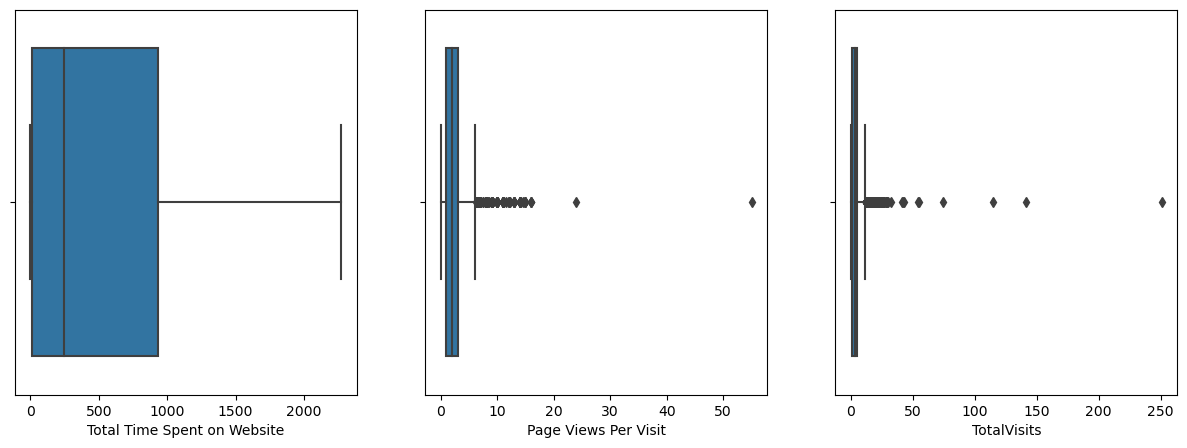

In [25]:
cols = ['Total Time Spent on Website', 'Page Views Per Visit','TotalVisits']
# Plotting for outliers
plt.figure(figsize = (15, 5))
for i, col in enumerate(cols):
    plt.subplot(1,3, i+1)
    sns.boxplot(df[col])
plt.show()

In [26]:
# Removing outliers using 1.5 IQR method
for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3 - q1

    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)

    df = df.loc[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

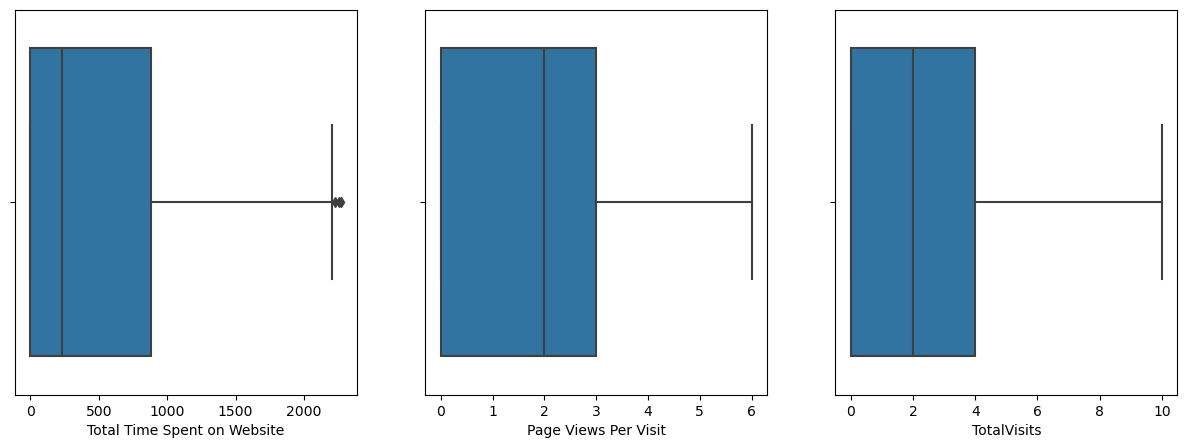

In [27]:
# Plotting for outliers
plt.figure(figsize = (15, 5))
for i, col in enumerate(cols):
    plt.subplot(1,3, i+1)
    sns.boxplot(df[col])
plt.show()

#### Observations

From the above visualization and analysis we come to the conclusion that the below columns are not relevant from business perspective- 

'What matters most to you in choosing a course','Search','Newspaper Article',
'X Education Forums','Newspaper','Digital Advertisement','Through Recommendations',
'A free copy of Mastering The Interview'

In [28]:
# We will drop all those columns that are not relevant from our business perspective.

new_df= df.copy()
new_df= new_df.drop(['What matters most to you in choosing a course','Search','Newspaper Article',
                     'X Education Forums','Newspaper','Digital Advertisement','Through Recommendations',
                     'A free copy of Mastering The Interview'],1)

In [29]:
# percentage rows retained
f'{round(100 * (new_df.shape[0] / df.shape[0]))} % row is retained after missing value and outliers treatment.'

'100 % row is retained after missing value and outliers treatment.'

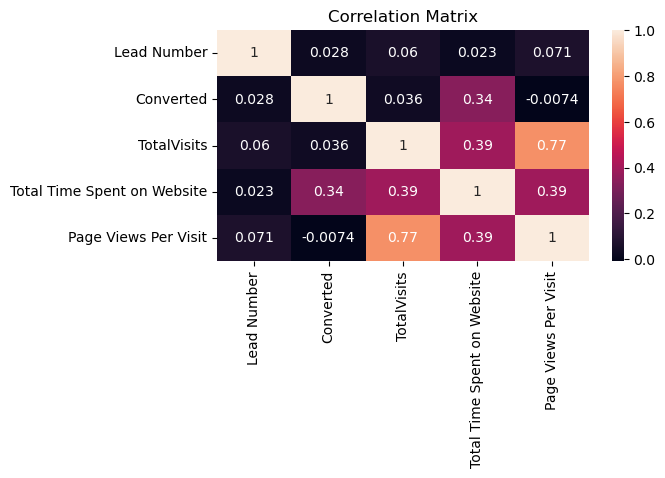

In [30]:
# To check the correlation among varibles
plt.figure(figsize=(6,3))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

## <font color= darkblue>Step 3. Data Preprocessing</font>

In [31]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474 entries, 0 to 9239
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Lead Number                      8474 non-null   int64  
 1   Lead Origin                      8474 non-null   object 
 2   Lead Source                      8474 non-null   object 
 3   Do Not Email                     8474 non-null   object 
 4   Do Not Call                      8474 non-null   object 
 5   Converted                        8474 non-null   int64  
 6   TotalVisits                      8474 non-null   float64
 7   Total Time Spent on Website      8474 non-null   int64  
 8   Page Views Per Visit             8474 non-null   float64
 9   Last Activity                    8474 non-null   object 
 10  Specialization                   8474 non-null   object 
 11  What is your current occupation  8474 non-null   object 
 12  Tags                

### <font color = maroon>3.1 Creating Dummy Variables</font>

In [32]:
# converting binary variables Yes/No to 1/0

yes_no_cols = ['Do Not Email', 'Do Not Call']
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

new_df[yes_no_cols] = new_df[yes_no_cols].apply(binary_map) 

In [33]:
columns_for_dummies = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization',
                       'What is your current occupation','Tags', 'City', 'Last Notable Activity']

# creating dummy columns
dummies = pd.get_dummies(new_df[columns_for_dummies], drop_first=True)

# concat with original data set
new_df = pd.concat([new_df, dummies], axis = 1)

# dropping the original columns
new_df.drop(columns_for_dummies, axis = 1, inplace = True)
new_df.shape

(8474, 80)

In [34]:
new_df.set_index('Lead Number', inplace = True)

In [35]:
new_df.head()

,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,...,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Other_Last_Notable_Activity,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed
Lead Number,,,,,,,,,,,,,,,,,,,,,
660737,0,0,0,0.0,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
660728,0,0,0,5.0,674,2.5,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
660727,0,0,1,2.0,1532,2.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
660719,0,0,0,1.0,305,1.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
660681,0,0,1,2.0,1428,1.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [36]:
# Putting feature variable to X
X = new_df.drop(['Converted'], axis=1)

# storing response variable to y
y = new_df['Converted']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [37]:
# Scaling for continuous variables:

scaler = StandardScaler()

X_train[['Total Time Spent on Website', 'Page Views Per Visit','TotalVisits']] = scaler.fit_transform(X_train[['Total Time Spent on Website', 'Page Views Per Visit',
                                                                                                               'TotalVisits']])

In [38]:
### Checking the conversion rate
conversion_rate = (sum(new_df['Converted'])/len(new_df['Converted'].index))*100
conversion_rate

37.65636063252301

#### The current conversion rate is around 38%. 
This is neither balanced nor heavily imbalanced. So we'll not have to do any special treatment for this dataset.

In [39]:
new_df.shape

(8474, 79)

## <font color = darkblue>4. Model Building</font>

In [40]:
# Logistic regression model with StatsModels
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5931
Model:                            GLM   Df Residuals:                     5852
Model Family:                Binomial   Df Model:                           78
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -961.99
Date:                Mon, 05 Jun 2023   Deviance:                       1924.0
Time:                        13:59:10   Pearson chi2:                 1.17e+04
No. Iterations:                    23   Pseudo R-squ. (CS):             0.6319
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -5.9634      2.447     -2.437      0.015     -10.759      -1.167
Do Not Email                                            -1.4124      0.364     -3.880      0.000      -2.126      -0.699
Do Not Call                                             19.8527   1.31e+05      0.000      1.000   -2.57e+05    2.57e+05
TotalVisits                                              0.1044      0.101      1.033      0.301      -0.094       0.302
Total Time Spent on Website                              1.0723      0.072     14.877      0.000       0.931       1.214
Page Views Per Visit                                    -0.1281      0.116     -1.108      0.268      -0.354       0.098
Lead Origin_Landing Page Submission                     -0.3435      0.264     -1.303      0.193      -0.860       0.173
Lead Origin_Lead Add Form                                0.7068      1.232      0.574      0.566      -1.708       3.122
Lead Origin_Lead Import                                  1.6554      1.738      0.952      0.341      -1.752       5.062
Lead Source_Facebook                                    -1.5439      1.729     -0.893      0.372      -4.932       1.844
Lead Source_Google                                       0.0791      0.183      0.433      0.665      -0.279       0.437
Lead Source_Olark Chat                                   1.0364      0.278      3.724      0.000       0.491       1.582
Lead Source_Organic Search                               0.3238      0.251      1.290      0.197      -0.168       0.816
Lead Source_Other_Platforms                              1.5816      0.902      1.754      0.080      -0.186       3.349
Lead Source_Reference                                    1.0838      1.321      0.821      0.412      -1.505       3.672
Lead Source_Referral Sites                               0.5885      0.542      1.086      0.277      -0.473       1.650
Lead Source_Welingak Website                             3.4447      1.595      2.159      0.031       0.318       6.571
Last Activity_Email Bounced                             -1.0228      0.975     -1.049      0.294      -2.933       0.888
Last Activity_Email Link Clicked                         1.1357      0.719      1.579      0.114      -0.274       2.546
Last Activity_Email Opened                               0.7192      0.445      1.617      0.106      -0.152       1.591
Last Activity_Form Submitted on Website                  0.6673      0.629      1.061      0.289      -0.565       1.900
Last Activity_Olark Chat Conversation                   -0.2964      0.462     -0.642      0.521      -1.202       0.609
Last Activity_Other_Activity                            -0

### <font color = maroon>4.1 Feature Selection using RFE</font>

In [41]:
# Creating object of LogisticRegression class from sklearn.linear_model
logreg = LogisticRegression()

# running RFE with 15 variables as output using sklearn.feature_selection
rfe = RFE(logreg, n_features_to_select=15)             
rfe = rfe.fit(X_train, y_train)

In [42]:
col = X_train.columns[rfe.support_]
col

Index(['Do Not Email', 'Lead Origin_Lead Add Form',
       'Lead Source_Welingak Website', 'Last Activity_Olark Chat Conversation',
       'What is your current occupation_Not Provided', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Not Provided',
       'Tags_Ringing', 'Tags_Will revert after reading the email',
       'Tags_invalid number', 'Tags_switched off', 'Tags_wrong number given',
       'Last Notable Activity_SMS Sent'],
      dtype='object')

### <font color = maroon>4.3 Assessing the model with StatsModel</font>

In [43]:
# Function to calculate VIF
def calc_vif(column, X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train[column].columns
    vif['VIF'] = [variance_inflation_factor(X_train[column].values, i) for i in range(X_train[column].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [44]:
# Adding constant
X_train_sm = sm.add_constant(X_train[col])

# Running sm.GLM
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5931
Model:                            GLM   Df Residuals:                     5915
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1148.8
Date:                Mon, 05 Jun 2023   Deviance:                       2297.6
Time:                        13:59:16   Pearson chi2:                 8.54e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.6080
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           -3.7262      0.219    -16.994      0.000      -4.156      -3.296
Do Not Email                                    -1.4833      0.247     -6.003      0.000      -1.968      -0.999
Lead Origin_Lead Add Form                        0.8823      0.421      2.094      0.036       0.057       1.708
Lead Source_Welingak Website                     2.2732      1.107      2.054      0.040       0.104       4.443
Last Activity_Olark Chat Conversation           -1.5218      0.239     -6.364      0.000      -1.990      -1.053
What is your current occupation_Not Provided    -2.4399      0.147    -16.549      0.000      -2.729      -2.151
Tags_Busy                                        3.0057      0.314      9.586      0.000       2.391       3.620
Tags_Closed by Horizzon                          8.6717      1.032      8.403      0.000       6.649      10.694
Tags_Lost to EINS                                8.6679      0.659     13.163      0.000       7.377       9.959
Tags_Not Provided                                3.9544      0.248     15.946      0.000       3.468       4.440
Tags_Ringing                                    -1.5820      0.345     -4.590      0.000      -2.257      -0.906
Tags_Will revert after reading the email         6.6167      0.272     24.298      0.000       6.083       7.150
Tags_invalid number                             -1.4870      1.057     -1.407      0.159      -3.558       0.584
Tags_switched off                               -2.2141      0.756     -2.929      0.003      -3.696      -0.732
Tags_wrong number given                        -20.8699   1.37e+04     -0.002      0.999   -2.69e+04    2.69e+04
Last Notable Activity_SMS Sent                   2.6009      0.139     18.708      0.000       2.328       2.873
================================================================================================================
"""

In [45]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
calc_vif(col, X_train)

,Features,VIF
8,Tags_Not Provided,5.06
4,What is your current occupation_Not Provided,4.72
14,Last Notable Activity_SMS Sent,1.64
1,Lead Origin_Lead Add Form,1.58
10,Tags_Will revert after reading the email,1.47
2,Lead Source_Welingak Website,1.40
3,Last Activity_Olark Chat Conversation,1.16
6,Tags_Closed by Horizzon,1.10
9,Tags_Ringing,1.09
0,Do Not Email,1.08


##### We can see VIF for Tags_Not Provided is >5. So we will drop it and rebuild model

In [46]:
# Dropping 'Tags_Not Provided'
col1 = col.drop('Tags_Not Provided',1)

#Model 2
X_train_sm = sm.add_constant(X_train[col1])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5931
Model:                            GLM   Df Residuals:                     5916
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1358.4
Date:                Mon, 05 Jun 2023   Deviance:                       2716.7
Time:                        13:59:17   Pearson chi2:                 9.48e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.5793
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           -1.6403      0.083    -19.707      0.000      -1.803      -1.477
Do Not Email                                    -1.3733      0.234     -5.878      0.000      -1.831      -0.915
Lead Origin_Lead Add Form                        1.1037      0.377      2.930      0.003       0.365       1.842
Lead Source_Welingak Website                     3.8359      1.089      3.521      0.000       1.701       5.971
Last Activity_Olark Chat Conversation           -1.4770      0.230     -6.417      0.000      -1.928      -1.026
What is your current occupation_Not Provided    -0.6975      0.116     -6.004      0.000      -0.925      -0.470
Tags_Busy                                        0.8041      0.247      3.252      0.001       0.319       1.289
Tags_Closed by Horizzon                          6.5318      1.011      6.463      0.000       4.551       8.513
Tags_Lost to EINS                                5.4731      0.596      9.182      0.000       4.305       6.641
Tags_Ringing                                    -3.9644      0.280    -14.167      0.000      -4.513      -3.416
Tags_Will revert after reading the email         4.4871      0.181     24.759      0.000       4.132       4.842
Tags_invalid number                             -3.8488      1.039     -3.705      0.000      -5.885      -1.813
Tags_switched off                               -4.5874      0.728     -6.298      0.000      -6.015      -3.160
Tags_wrong number given                        -23.1987   1.34e+04     -0.002      0.999   -2.63e+04    2.63e+04
Last Notable Activity_SMS Sent                   2.9140      0.127     22.911      0.000       2.665       3.163
================================================================================================================
"""

In [47]:
# again checking the VIF now:
calc_vif(col1, X_train)

,Features,VIF
1,Lead Origin_Lead Add Form,1.57
13,Last Notable Activity_SMS Sent,1.54
9,Tags_Will revert after reading the email,1.43
2,Lead Source_Welingak Website,1.32
4,What is your current occupation_Not Provided,1.22
3,Last Activity_Olark Chat Conversation,1.15
6,Tags_Closed by Horizzon,1.10
8,Tags_Ringing,1.08
0,Do Not Email,1.07
5,Tags_Busy,1.03


##### We can see that all the value for VIFs is below 5. But we have high p-value for Tags_wrong number given.

We will drop this column and rebuild model

In [48]:
# Dropping 'Tags_wrong number given' as p-value is 0.999
col2 = col1.drop('Tags_wrong number given',1)

X_train_sm = sm.add_constant(X_train[col2])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5931
Model:                            GLM   Df Residuals:                     5917
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1370.7
Date:                Mon, 05 Jun 2023   Deviance:                       2741.4
Time:                        13:59:17   Pearson chi2:                 9.22e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5775
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           -1.6734      0.083    -20.090      0.000      -1.837      -1.510
Do Not Email                                    -1.4469      0.232     -6.246      0.000      -1.901      -0.993
Lead Origin_Lead Add Form                        1.1432      0.375      3.045      0.002       0.407       1.879
Lead Source_Welingak Website                     3.8499      1.089      3.535      0.000       1.715       5.985
Last Activity_Olark Chat Conversation           -1.4742      0.230     -6.399      0.000      -1.926      -1.023
What is your current occupation_Not Provided    -0.6414      0.115     -5.572      0.000      -0.867      -0.416
Tags_Busy                                        0.8622      0.245      3.516      0.000       0.382       1.343
Tags_Closed by Horizzon                          6.5602      1.011      6.491      0.000       4.579       8.541
Tags_Lost to EINS                                5.4805      0.596      9.200      0.000       4.313       6.648
Tags_Ringing                                    -3.8800      0.279    -13.931      0.000      -4.426      -3.334
Tags_Will revert after reading the email         4.5264      0.181     24.978      0.000       4.171       4.882
Tags_invalid number                             -3.7581      1.038     -3.620      0.000      -5.793      -1.723
Tags_switched off                               -4.4942      0.728     -6.175      0.000      -5.921      -3.068
Last Notable Activity_SMS Sent                   2.8525      0.125     22.867      0.000       2.608       3.097
================================================================================================================
"""

In [49]:
calc_vif(col2, X_train)

,Features,VIF
1,Lead Origin_Lead Add Form,1.57
12,Last Notable Activity_SMS Sent,1.53
9,Tags_Will revert after reading the email,1.43
2,Lead Source_Welingak Website,1.32
4,What is your current occupation_Not Provided,1.22
3,Last Activity_Olark Chat Conversation,1.15
6,Tags_Closed by Horizzon,1.10
8,Tags_Ringing,1.08
0,Do Not Email,1.07
5,Tags_Busy,1.03


##### We got features with low VIF and low p-value. We are accepting this model for now.

## <font color = darkblue>5. Model Evaluation</font>

In [50]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

Lead Number
618332    0.089906
605316    0.998940
655685    0.003859
581653    0.157972
619035    0.631279
624090    0.089906
645483    0.945474
623355    0.089906
591659    0.022716
641106    0.764786
dtype: float64

In [51]:
# Reshaping y_train_pred
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.08990584, 0.99894028, 0.00385924, 0.15797205, 0.63127942,
       0.08990584, 0.94547443, 0.08990584, 0.02271636, 0.76478586])

In [52]:
#Creating a dataframe with the actual converted flag and the predicted probabilities

y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['Lead Number'] = y_train.index
y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number
0,1,0.089906,618332
1,1,0.998940,605316
2,0,0.003859,655685
3,0,0.157972,581653
4,1,0.631279,619035


##### Creating new column 'predicted' with 1 if Converted_Prob > 0.5 else 0. 

Since the logistic curve gives you just the probabilities and not the actual classification of 'Converted' and 'Not Converted', you need to find a threshold probability to classify customers as 'Converted' and 'Not Converted'. 

- Here, we choose 0.5 as an arbitrary cutoff wherein if the probability of a particular customer churning is less than 0.5, you'd classify it as 'Not Converted' and if it's greater than 0.5, you'd classify it as 'Converted'.

In [53]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number,predicted
0,1,0.089906,618332,0
1,1,0.998940,605316,1
2,0,0.003859,655685,0
3,0,0.157972,581653,0
4,1,0.631279,619035,1


In [54]:
# Confusion matrix 
print("For model with arbitrary cut-off 0.5")
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print("\nConfusion Matrix:")
print(confusion)

# Let's check the overall accuracy.
print("\nOverall Accuracy:", metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

For model with arbitrary cut-off 0.5

Confusion Matrix:
[[3549  154]
 [ 302 1926]]

Overall Accuracy: 0.9231158320687911


#### <font color = maroon>The model has 92% accuracy. </font>

In [55]:
# Let's check the specificity and sensitivity.
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity
# It tells how many conversions have been identified correctly
sensitivity = TP / float(TP+FN)

# Let us calculate specificity
# It tells of all how we correctly detect.
specificity = TN / float(TN+FP)

# False postive rate - predicting converted when lead have not converted
false_postive_rate = FP/ float(TN+FP)

# positive predictive value 
positive_predictive_value = TP / float(TP+FP)

# Negative predictive value
negative_predictive_value = TN / float(TN+ FN)

print("sensitivity:", sensitivity)
print("specificity:", specificity)
print("false_postive_rate:", false_postive_rate)
print("positive_predictive_value:", positive_predictive_value)
print("negative_predictive_value:", negative_predictive_value)

sensitivity: 0.8644524236983842
specificity: 0.9584120982986768
false_postive_rate: 0.04158790170132325
positive_predictive_value: 0.9259615384615385
negative_predictive_value: 0.9215788106985199


### <font color = maroon>Sensitivity of the model is 86%</font>

### <font color = maroon>Plotting the ROC Curve:</font>
An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [56]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

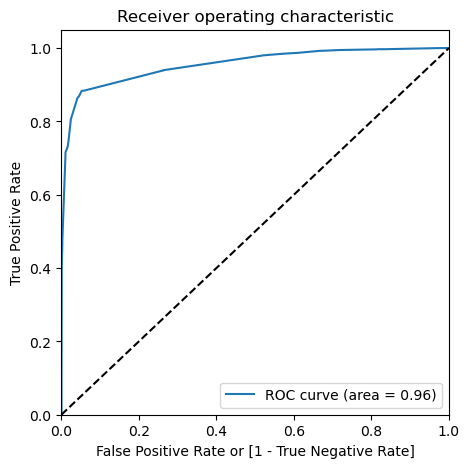

In [57]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

#### <font color = darkgreen>The model looks good as it far away from the diagonal. 96% area is covered under the curve.</font>

### <font color = maroon>Finding the optimal cut off point</font>

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [58]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.089906,618332,0,1,0,0,0,0,0,0,0,0,0
1,1,0.998940,605316,1,1,1,1,1,1,1,1,1,1,1
2,0,0.003859,655685,0,1,0,0,0,0,0,0,0,0,0
3,0,0.157972,581653,0,1,1,0,0,0,0,0,0,0,0
4,1,0.631279,619035,1,1,1,1,1,1,1,1,0,0,0


In [59]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.375653  1.000000  0.000000
0.1   0.1  0.812173  0.939408  0.735620
0.2   0.2  0.921936  0.883752  0.944910
0.3   0.3  0.923453  0.882855  0.947880
0.4   0.4  0.922610  0.866697  0.956252
0.5   0.5  0.923116  0.864452  0.958412
0.6   0.6  0.923116  0.864452  0.958412
0.7   0.7  0.912156  0.806553  0.975695
0.8   0.8  0.890575  0.736984  0.982987
0.9   0.9  0.886697  0.715889  0.989468


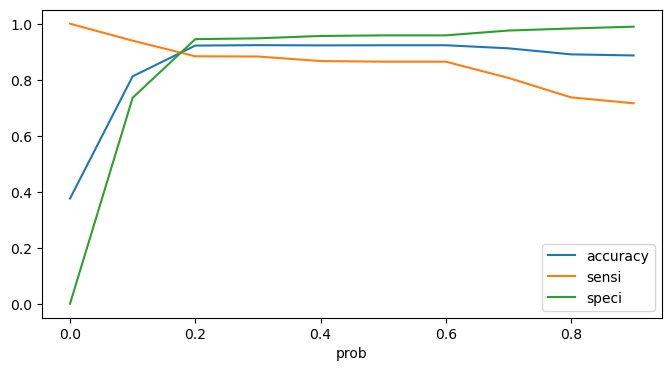

In [60]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### <font color = darkgreen>The accuracy, sensitivity and specificity lines are intersecting at 0.2 probability. So, we will proceed with this value.</font>
### <font color = maroon>Evaluating the model with optimal probability cutoff as 0.2</font>

In [61]:
# From the above plot we get to know that 0.29 is the optimum point to take it as a cut-off
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.089906,618332,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.998940,605316,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.003859,655685,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.157972,581653,0,1,1,0,0,0,0,0,0,0,0,0
4,1,0.631279,619035,1,1,1,1,1,1,1,1,0,0,0,1


In [62]:
# Accuracy of model with cut-off 0.2
accuracy = metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
print("Accuracy:", accuracy)

confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
print("\nConfusion Matrix:")
print(confusion2)

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity
sensitivity = TP / float(TP+FN)

# Let us calculate specificity
specificity = TN / float(TN+FP)

# False postive rate - predicting converted when lead have not converted
false_postive_rate = FP/ float(TN+FP)

# positive predictive value 
positive_predictive_value = TP / float(TP+FP)

# Negative predictive value
negative_predictive_value = TN / float(TN+ FN)

print("\nsensitivity:", sensitivity)
print("specificity:", specificity)
print("false_postive_rate:", false_postive_rate)
print("positive_predictive_value:", positive_predictive_value)
print("negative_predictive_value:", negative_predictive_value)

Accuracy: 0.9219355926487944

Confusion Matrix:
[[3499  204]
 [ 259 1969]]

sensitivity: 0.8837522441651705
specificity: 0.9449095328112341
false_postive_rate: 0.05509046718876587
positive_predictive_value: 0.9061205706396687
negative_predictive_value: 0.9310803618946248


### <font color = darkgreen>Sensitivity of the model is now 88%</font>

### <font color = maroon>Precision and Recall</font>

In [63]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted)
print("Confusion Matrix:")
print(confusion)

#Precision = TP / TP + FP
precision = confusion[1,1]/(confusion[0,1]+confusion[1,1])

#Recall = TP / TP + FN
recall = confusion[1,1]/(confusion[1,0]+confusion[1,1])

print("\nprecision:", precision)
print("recall:", recall)

Confusion Matrix:
[[3549  154]
 [ 302 1926]]

precision: 0.9259615384615385
recall: 0.8644524236983842


In [64]:
#Using sklearn to calculate the same
from sklearn.metrics import precision_score, recall_score
print("Precision:", precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print("Recall:", recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

Precision: 0.9259615384615385
Recall: 0.8644524236983842


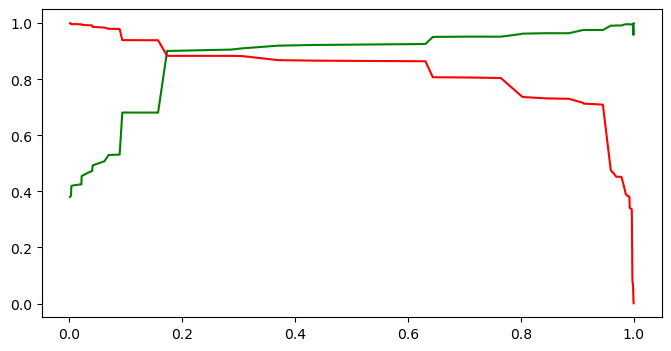

In [65]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

## <font color = darkblue>Step 6. Making Predictions on the test dataset</font>

In [66]:
#Scaling continuous vars of test data
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits',
                                                            'Total Time Spent on Website','Page Views Per Visit']])

In [67]:
X_test = X_test[col2]
X_test_sm = sm.add_constant(X_test)

# Making prediction on the test set:
y_test_pred = res.predict(X_test_sm)

In [68]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

#Putting Lead Number to index
y_test_df['Lead Number'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_test_df.reset_index(drop=True, inplace=True)
y_pred_1.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [69]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})
y_pred_final.head()

,Converted,Lead Number,Converted_Prob
0,0,590700,0.004358
1,1,594833,0.996683
2,0,600817,0.089906
3,0,656621,0.003859
4,0,580732,0.042278


In [70]:
# Creating predicted column with 0.2 probability cutoff
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.2 else 0)

y_pred_final.head()

,Converted,Lead Number,Converted_Prob,final_predicted
0,0,590700,0.004358,0
1,1,594833,0.996683,1
2,0,600817,0.089906,0
3,0,656621,0.003859,0
4,0,580732,0.042278,0


In [71]:
# Overall Accuracy
accuracy = metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)
print("Accuracy:", accuracy)

confusion3 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
print("\nConfusion Matrix:")
print(confusion3)

TP = confusion3[1,1] # true positive 
TN = confusion3[0,0] # true negatives
FP = confusion3[0,1] # false positives
FN = confusion3[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("\nSensitivity:", TP / float(TP+FN))

# Let us calculate specificity
print("Specificity:", TN / float(TN+FP))

Accuracy: 0.9233189146677153

Confusion Matrix:
[[1494   86]
 [ 109  854]]

Sensitivity: 0.8868120456905504
Specificity: 0.9455696202531646


### <font color = maroon>Calculating the lead score</font>
Lead Score = 100 * ConversionProbability

In [72]:
# Selecting the test dataset along with the Conversion Probability and final predicted value for 'Converted'
leads_test_pred = y_pred_final.copy()
leads_test_pred.head()

,Converted,Lead Number,Converted_Prob,final_predicted
0,0,590700,0.004358,0
1,1,594833,0.996683,1
2,0,600817,0.089906,0
3,0,656621,0.003859,0
4,0,580732,0.042278,0


In [73]:
# Selecting the train dataset along with the Conversion Probability and final predicted value for 'Converted'
leads_train_pred = y_train_pred_final.copy()
leads_train_pred.head()

,Converted,Converted_Prob,Lead Number,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.089906,618332,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.998940,605316,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.003859,655685,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.157972,581653,0,1,1,0,0,0,0,0,0,0,0,0
4,1,0.631279,619035,1,1,1,1,1,1,1,1,0,0,0,1


In [74]:
# Dropping unnecessary columns from train dataset
leads_train_pred = leads_train_pred[['Lead Number','Converted','Converted_Prob','final_predicted']]
leads_train_pred.head()

,Lead Number,Converted,Converted_Prob,final_predicted
0,618332,1,0.089906,0
1,605316,1,0.998940,1
2,655685,0,0.003859,0
3,581653,0,0.157972,0
4,619035,1,0.631279,1


In [75]:
# Concatenating the 2 dataframes train and test along the rows with the append() function
lead_full_pred = leads_train_pred.append(leads_test_pred)
lead_full_pred.head()

,Lead Number,Converted,Converted_Prob,final_predicted
0,618332,1,0.089906,0
1,605316,1,0.998940,1
2,655685,0,0.003859,0
3,581653,0,0.157972,0
4,619035,1,0.631279,1


In [76]:
# Inspecting the shape of the final dataframe and the test and train dataframes
print(leads_train_pred.shape)
print(leads_test_pred.shape)
print(lead_full_pred.shape)

(5931, 4)
(2543, 4)
(8474, 4)


In [77]:
# Ensuring the Lead Numbers are unique for each lead in the finl dataframe
len(lead_full_pred['Lead Number'].unique().tolist())

8474

In [78]:
# Calculating the Lead Score value
# Lead Score = 100 * Conversion_Prob
lead_full_pred['Lead_Score'] = lead_full_pred['Converted_Prob'].apply(lambda x : round(x*100))
lead_full_pred.head()

,Lead Number,Converted,Converted_Prob,final_predicted,Lead_Score
0,618332,1,0.089906,0,9
1,605316,1,0.998940,1,100
2,655685,0,0.003859,0,0
3,581653,0,0.157972,0,16
4,619035,1,0.631279,1,63


In [79]:
# Making the Lead Number column as index

lead_full_pred = lead_full_pred.set_index('Lead Number').sort_index(axis = 0, ascending = True)
lead_full_pred.head()

,Converted,Converted_Prob,final_predicted,Lead_Score
Lead Number,,,,
579533,1,0.945474,1,95
579538,1,0.631279,1,63
579545,0,0.017534,0,2
579546,0,0.764786,1,76
579564,1,0.803152,1,80


In [80]:
# Selecting the coefficients of the selected features from our final model excluding the intercept

pd.options.display.float_format = '{:.2f}'.format
new_params = res.params[1:]
new_params

Do Not Email                                   -1.45
Lead Origin_Lead Add Form                       1.14
Lead Source_Welingak Website                    3.85
Last Activity_Olark Chat Conversation          -1.47
What is your current occupation_Not Provided   -0.64
Tags_Busy                                       0.86
Tags_Closed by Horizzon                         6.56
Tags_Lost to EINS                               5.48
Tags_Ringing                                   -3.88
Tags_Will revert after reading the email        4.53
Tags_invalid number                            -3.76
Tags_switched off                              -4.49
Last Notable Activity_SMS Sent                  2.85
dtype: float64

In [81]:
# Getting a relative coeffient value for all the features wrt the feature with the highest coefficient

feature_importance = new_params
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance

Do Not Email                                   -22.06
Lead Origin_Lead Add Form                       17.43
Lead Source_Welingak Website                    58.69
Last Activity_Olark Chat Conversation          -22.47
What is your current occupation_Not Provided    -9.78
Tags_Busy                                       13.14
Tags_Closed by Horizzon                        100.00
Tags_Lost to EINS                               83.54
Tags_Ringing                                   -59.14
Tags_Will revert after reading the email        69.00
Tags_invalid number                            -57.29
Tags_switched off                              -68.51
Last Notable Activity_SMS Sent                  43.48
dtype: float64

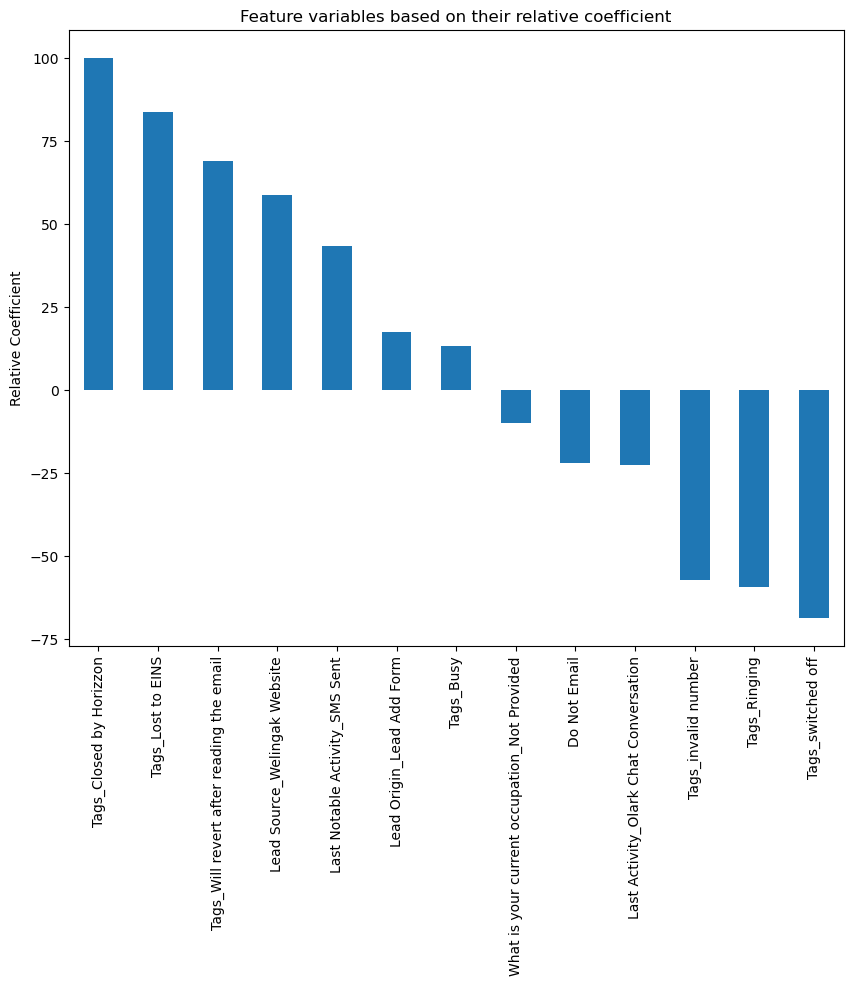

In [82]:
# Plot showing the feature variables based on their relative coefficient values
plt.figure(figsize = (10,8))
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature variables based on their relative coefficient')
plt.ylabel('Relative Coefficient')
plt.show()

In [83]:
# Selecting Top 3 features which contribute most towards the probability of a lead getting converted

pd.DataFrame(feature_importance).reset_index().sort_values(by=0,ascending=False).head(3)

,index,0
6,Tags_Closed by Horizzon,100.00
7,Tags_Lost to EINS,83.54
9,Tags_Will revert after reading the email,69.00


## <font color = darkgreen>Conclusion</font>

The top three variables that contribute most towards probability of lead getting 
converted are:
- Tags - Closed by Horizzon, Lost to EINS, We will revert after reading the email
- Lead Source – Welingak Website
- Last Notable Activity – SMS Sent

Top 3 variables that need improvement to convert a lead are:
- Tags_Ringing
- Tag_switched off
- Tags_invalid number